---
# Figure 12-14: Beached liklihood, volume, timing (4-panels)
---

The aggregated netcdf and plotting methods used here come from **Susan Allen**. 

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

This notebook relies on functions in `monte_carlo_utils.py` and requires the inclusion of the directory with this script, namely `../../../scripts`, in PYTHONPATH, e.g.:
```
export PYTHONPATH=$PYTHONPATH:/path/to/analysis-rachael/scripts
```
or uncommenting the following lines to import the scripts directory using sys: 
```
import sys
sys.path.insert(0, '../../../scripts')
```

In [1]:
# import cmocean.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import cmocean.cm as cm
import numpy as np
import pandas as pd
import xarray as xr
import os
from pathlib import Path
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
#from salishsea_tools import viz_tools
import matplotlib

# set colormap so it's white (water) and papayawhip (land)
my_cmap = matplotlib.cm.get_cmap('Greens').copy()
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')


%matplotlib inline

oil_dict = {"akns":"ANS",
            "oils":"all oils",
           "bunker":"Bunker-C",
           "diesel":"Diesel",
           "dilbit":"Dilbit",
           "gas":"Diesel",
           "jet":"Diesel",
           "other":"Bunker-C"}

MIDOSScolors={
    'ANS': 'darkslategrey',
    'Bunker-C':'teal',
    'Dilbit':'slategrey',
    'Diesel':'darkgoldenrod',
}

# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']

# define directory paths
if os.sys.platform=="darwin": # For Shuga
    graphics_directory = Path(
         '/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/JGR_graphics'
    )
    # Aggregated files path
    agg_dir = Path('/Volumes/Elements/MIDOSS_Data/aggregated_spills/')
    # monte carlo spills file
    spill_dir = Path('/Volumes/Elements/MIDOSS_Data/spill_files_091921/')
    # graphics style
    plt.style.use(r"../../style_templates/JGR2023_matplotlibrc.template")
else:
    # Aggregated files path
    agg_dir = Path('/data/sallen/MIDOSS/aggregated_spills_files/')
    # monte carlo spills file
    spill_dir = Path('/ocean/rmueller/MIDOSS/spill_files_091921/')
    # MEOPAR ASM graphics directory
    graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/beaching')
    



In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
tmask = 1- mesh_mask.tmaskutil[0]
divarea = 1/(mesh_mask.e1t[0, 1:-1, 1:-1] * mesh_mask.e2t[0, 1:-1, 1:-1])
# e1t = dx
# e2t = dy
# alength = 1/(length scale), where length is the largest of dx,dy
alength = 1/np.maximum(mesh_mask.e1t[0, 1:-1:, 1:-1], mesh_mask.e2t[0, 1:-1, 1:-1])
mesh_mask.close()

# set plotting values
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

# specify transparancy for land mask
alpha_land = 0.2

# beaching time colormap
minColor = 0.1
maxColor = 0.85
thermal_r_t = truncate_colormap(cm.thermal_r, minColor, maxColor)

In [4]:
eps = 1e-7
mcsize = 49
perol = 1
absol = np.log(perol+1)
absol_time = 0.5
perol_time = 0.15
bv_perol = perol

oil_types = ['akns','bunker','diesel','dilbit','oils']
ma_beaching_pres={}
ma_beach_oil={}
den={}
beachoil_ste={}
beachedtime_ste={}
beachedoil={}
beachedoil_sum={}
beachedtime={}
presence={}

# load information for each oil type (and all oil combined)
for oilname in oil_types:
    thefile = agg_dir/f'fiftieth_55_{oilname}.nc'
    oil = xr.open_dataset(thefile)

    ma_beaching_pres[oilname] = np.ma.masked_array(
        oil.beachpresence, oil.beachpresence == 0
    )
    ma_beach_oil[oilname] = np.ma.masked_array(
        oil.beaching_oil[0]/(oil.beachpresence + eps), 
        oil.beachpresence == 0
    )
    den[oilname] = np.minimum(np.array(oil.beachpresence) + eps, mcsize)
    beachoil_ste[oilname] = np.std(
        oil.beaching_oil/(oil.beachpresence + eps), axis=0, ddof=1
    ) / np.sqrt(den[oilname])
    # beached volume (geometric mean)
    beachedoil[oilname] = np.ma.masked_array(
        oil.beaching_oil[0]/(oil.beachpresence + eps), 
        (oil.beachpresence <= 1) | ((beachoil_ste[oilname] > absol))
    )
    # toward calculating likelihood
    presence[oilname]=np.ma.masked_array(oil.beachpresence, 
        (oil.beachpresence <= 1) | ((beachoil_ste[oilname] > absol))
    )
    # beached time (geometric mean)
    beachedtime_ste[oilname] = np.std(oil.beaching_time, axis=0, ddof=1) / np.sqrt(den[oilname])
    beachedtime[oilname]=np.ma.masked_array(
        oil.beaching_time[0]/(oil.beachpresence + eps), 
        (oil.beachpresence <= 1) | 
        ((beachedtime_ste[oilname]/(oil.beachpresence+eps) > absol_time) | 
        (beachedtime_ste[oilname] > absol_time*oil.beaching_time[0])))

    oil.close()

# likelihood of beaching

akns: 0.68 [min] - 33.33 max] 
bunker: 14.29 [min] - 100.00 max] 
diesel: 10.53 [min] - 100.00 max] 
oils: 100.00 [min] - 100.00 max] 


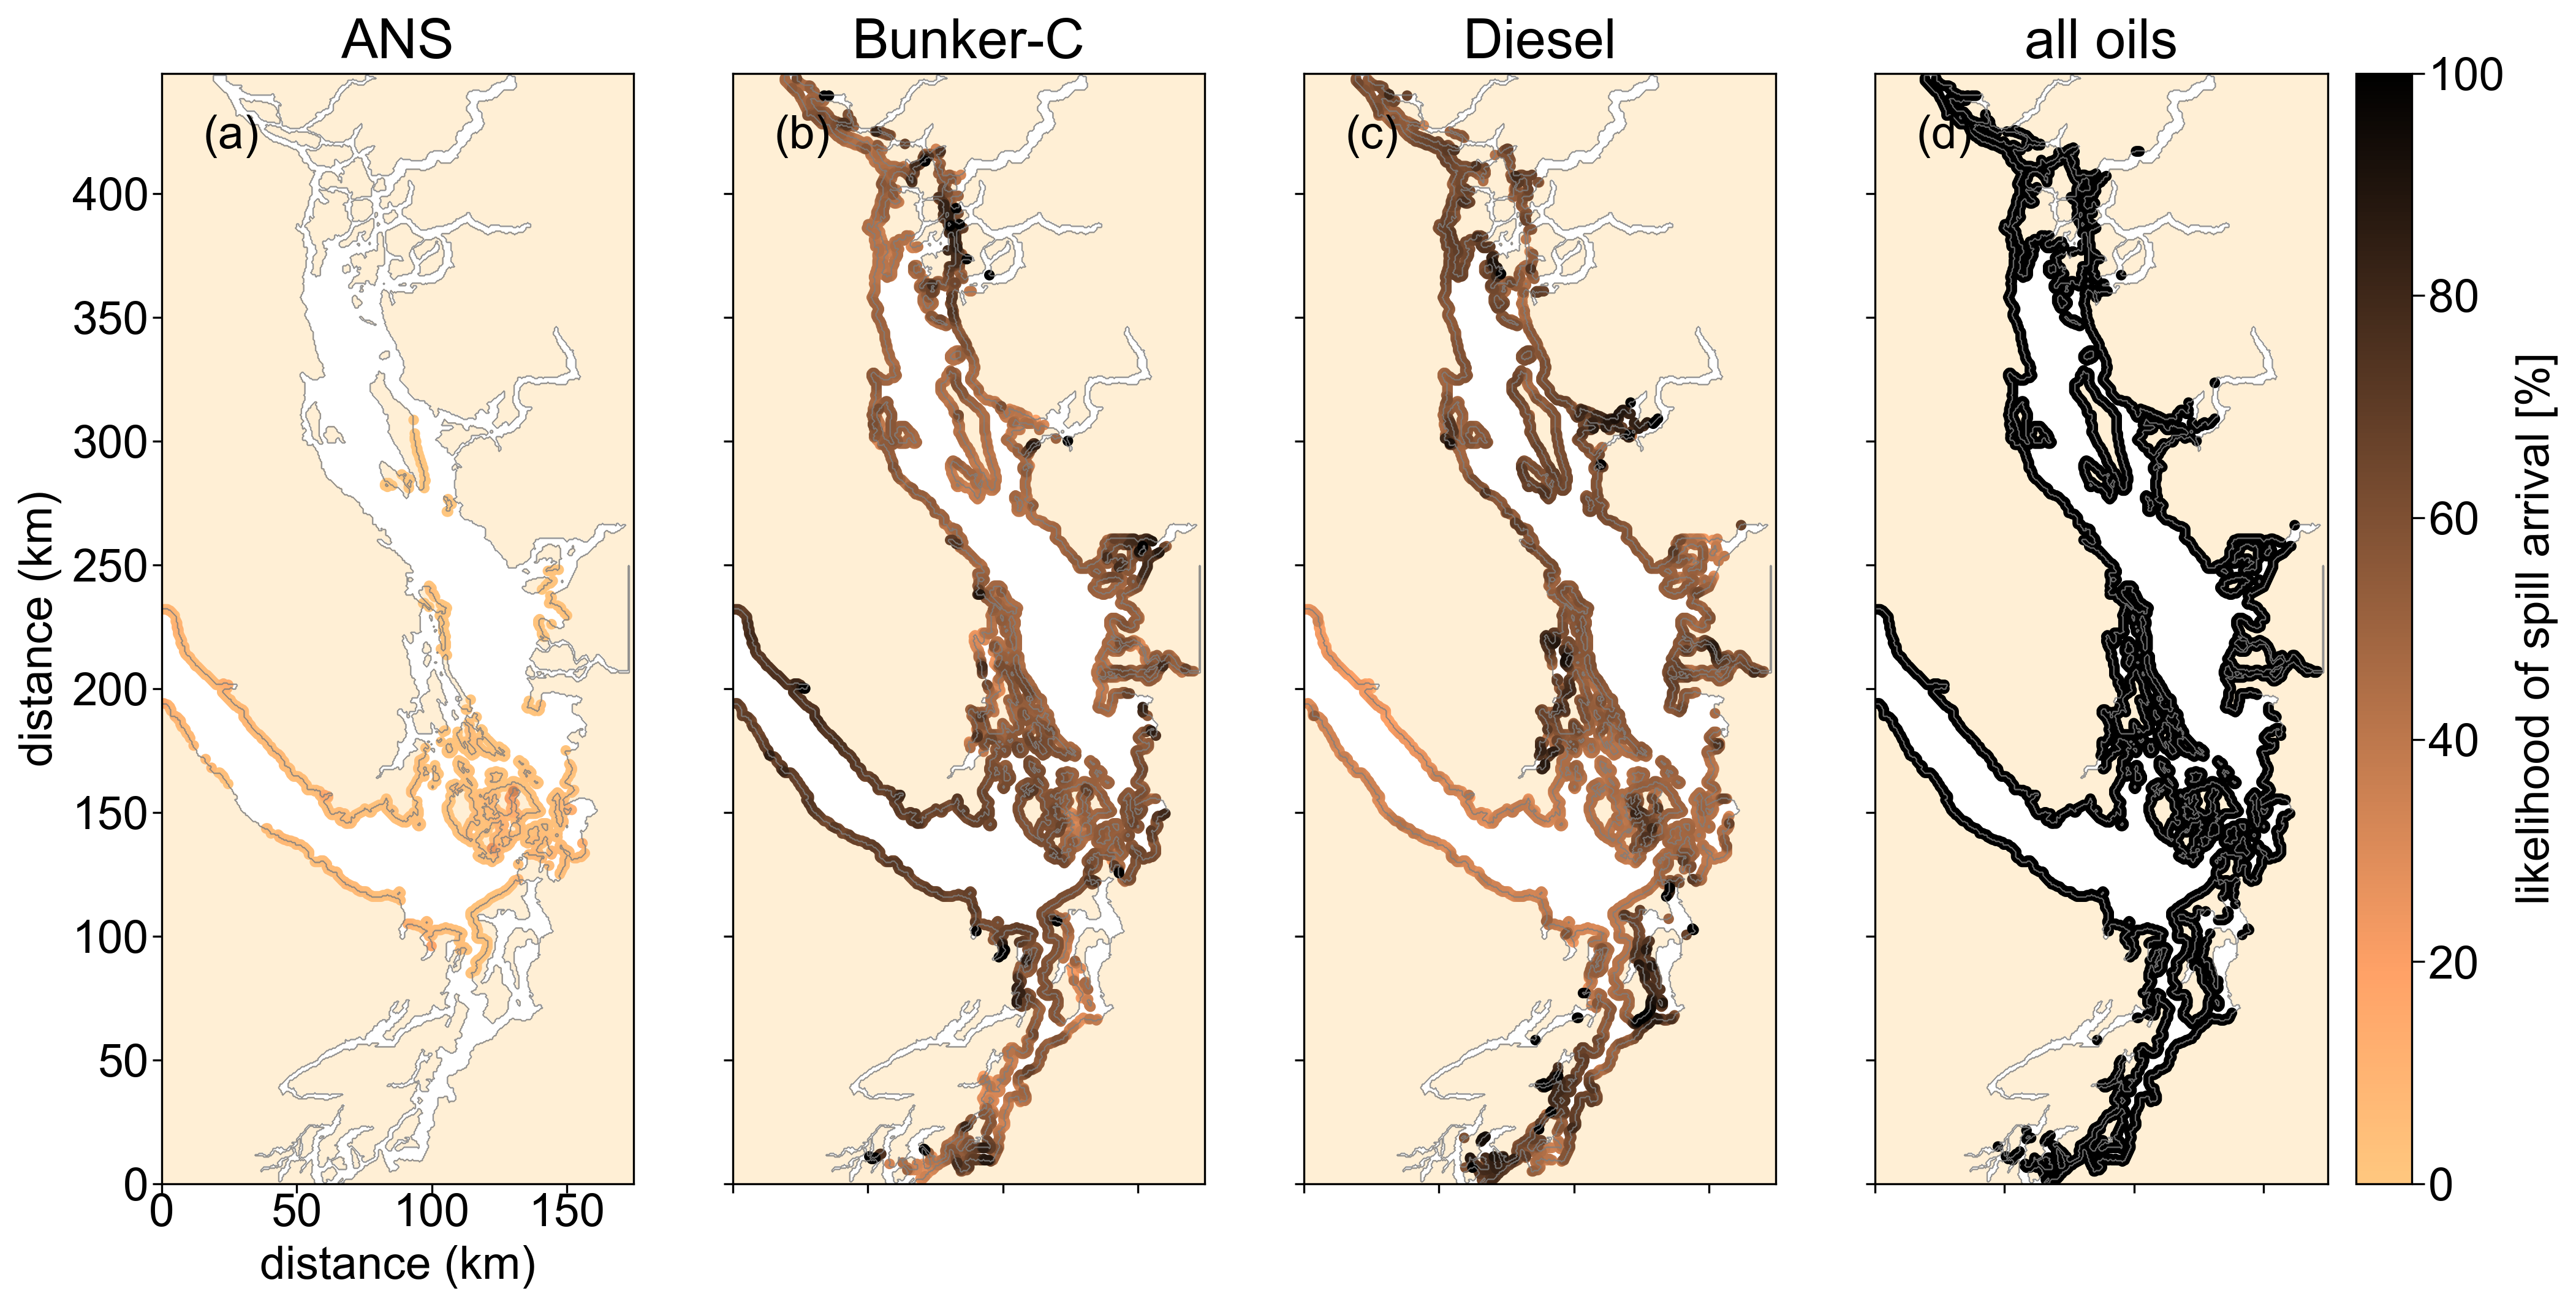

In [6]:
oil_types = ['akns','bunker','diesel','oils']

fig, ax = plt.subplots(1,len(oil_types), figsize = (16,8),
          gridspec_kw={'width_ratios': [1 ,1, 1, 1.2]})
# Add plots for different oil types


#linewidth for land mask
lw=0.5

# color of shoreline
ec='grey'

for idx,oilname in enumerate(oil_types):
    # create dataframe for oil type
    likelihood = 100*presence[oilname]/presence['oils']
    print(f'{oilname}: {likelihood.min():1.2f} [min] - {likelihood.max():1.2f} max] ')
    #beached_oil = np.exp(beachedoil[oilname])
    # get the x,y values in vector form
    coords=np.asarray(np.argwhere(likelihood))
    x, y = coords[:, 0], coords[:, 1]
    # get the beached oil in vector form
    likelihood_1d = likelihood.compressed()
    df = pd.DataFrame(data={'x': x,
                        'y': y,
                        'z': likelihood_1d})
    df.sort_values('z', ascending=True, inplace=True)
    # plotting the land mask
    ax[idx].pcolormesh(1.8*tmask[1:, 1:], cmap=my_cmap, 
                  vmin=.1, vmax=.8)
    ax[idx].contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
#     ax[idx].pcolormesh(1.8*tmask[1:, 1:], cmap='Greens', 
#                   vmin=-0.2, vmax=1.6, alpha=alpha_land)    
    sc=ax[idx].scatter(df.y,df.x,c=df.z, 
          s=10, 
          cmap = 'copper_r',
          vmin=0, vmax=100
    )
     
    # Use dx=440/1000 scale to make "nice" x-axis label intervals 
    xticks = np.arange(0, 200, 50)/.44
    ax[idx].set_xticks(xticks)
    if idx != 0:
        ax[idx].set_xticklabels('')
        ax[idx].set_yticklabels('')
    else:
        # convert axis labels to km
        ax[idx].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000)))
        ax[idx].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000)))

        ax[idx].set_ylabel('distance (km)')
        ax[idx].set_xlabel('distance (km)')
    ax[idx].set_title(oil_dict[oilname])
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax[idx])
# cax = divider.append_axes('right', size="20%", pad=0.8,)
#cbar = fig.colorbar(sc, cax=cax, orientation='vertical');
cbar = plt.colorbar(sc,orientation='vertical')
cbar.ax.tick_params(which='major', length=5, color='k') 
cbar.set_label('likelihood of spill arrival [%]');

for idx in [0,1,2,3]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
    
plt.savefig(graphics_directory/'Figure12_MuellerEtAlJGR_likelihood.png')

In [7]:
# volume of beaching

In [8]:
# #Ticks 

# https://matplotlib.org/stable/users/explain/axes/axes_ticks.html#sphx-glr-users-explain-axes-axes-ticks-py

# fig, axs = plt.subplots(2, 1, figsize=(5.4, 5.4), layout='constrained')
# x = np.arange(100)
# for nn, ax in enumerate(axs):
#     ax.plot(x, x)
#     if nn == 1:
#         ax.set_title('Manual ticks')
#         ax.set_yticks(np.arange(0, 100.1, 100/3))
#         xticks = np.arange(0.50, 101, 20)
#         xlabels = [f'\\${x:1.2f}' for x in xticks]
#         ax.set_xticks(xticks, labels=xlabels)
#     else:
#         ax.set_title('Automatic ticks')
        

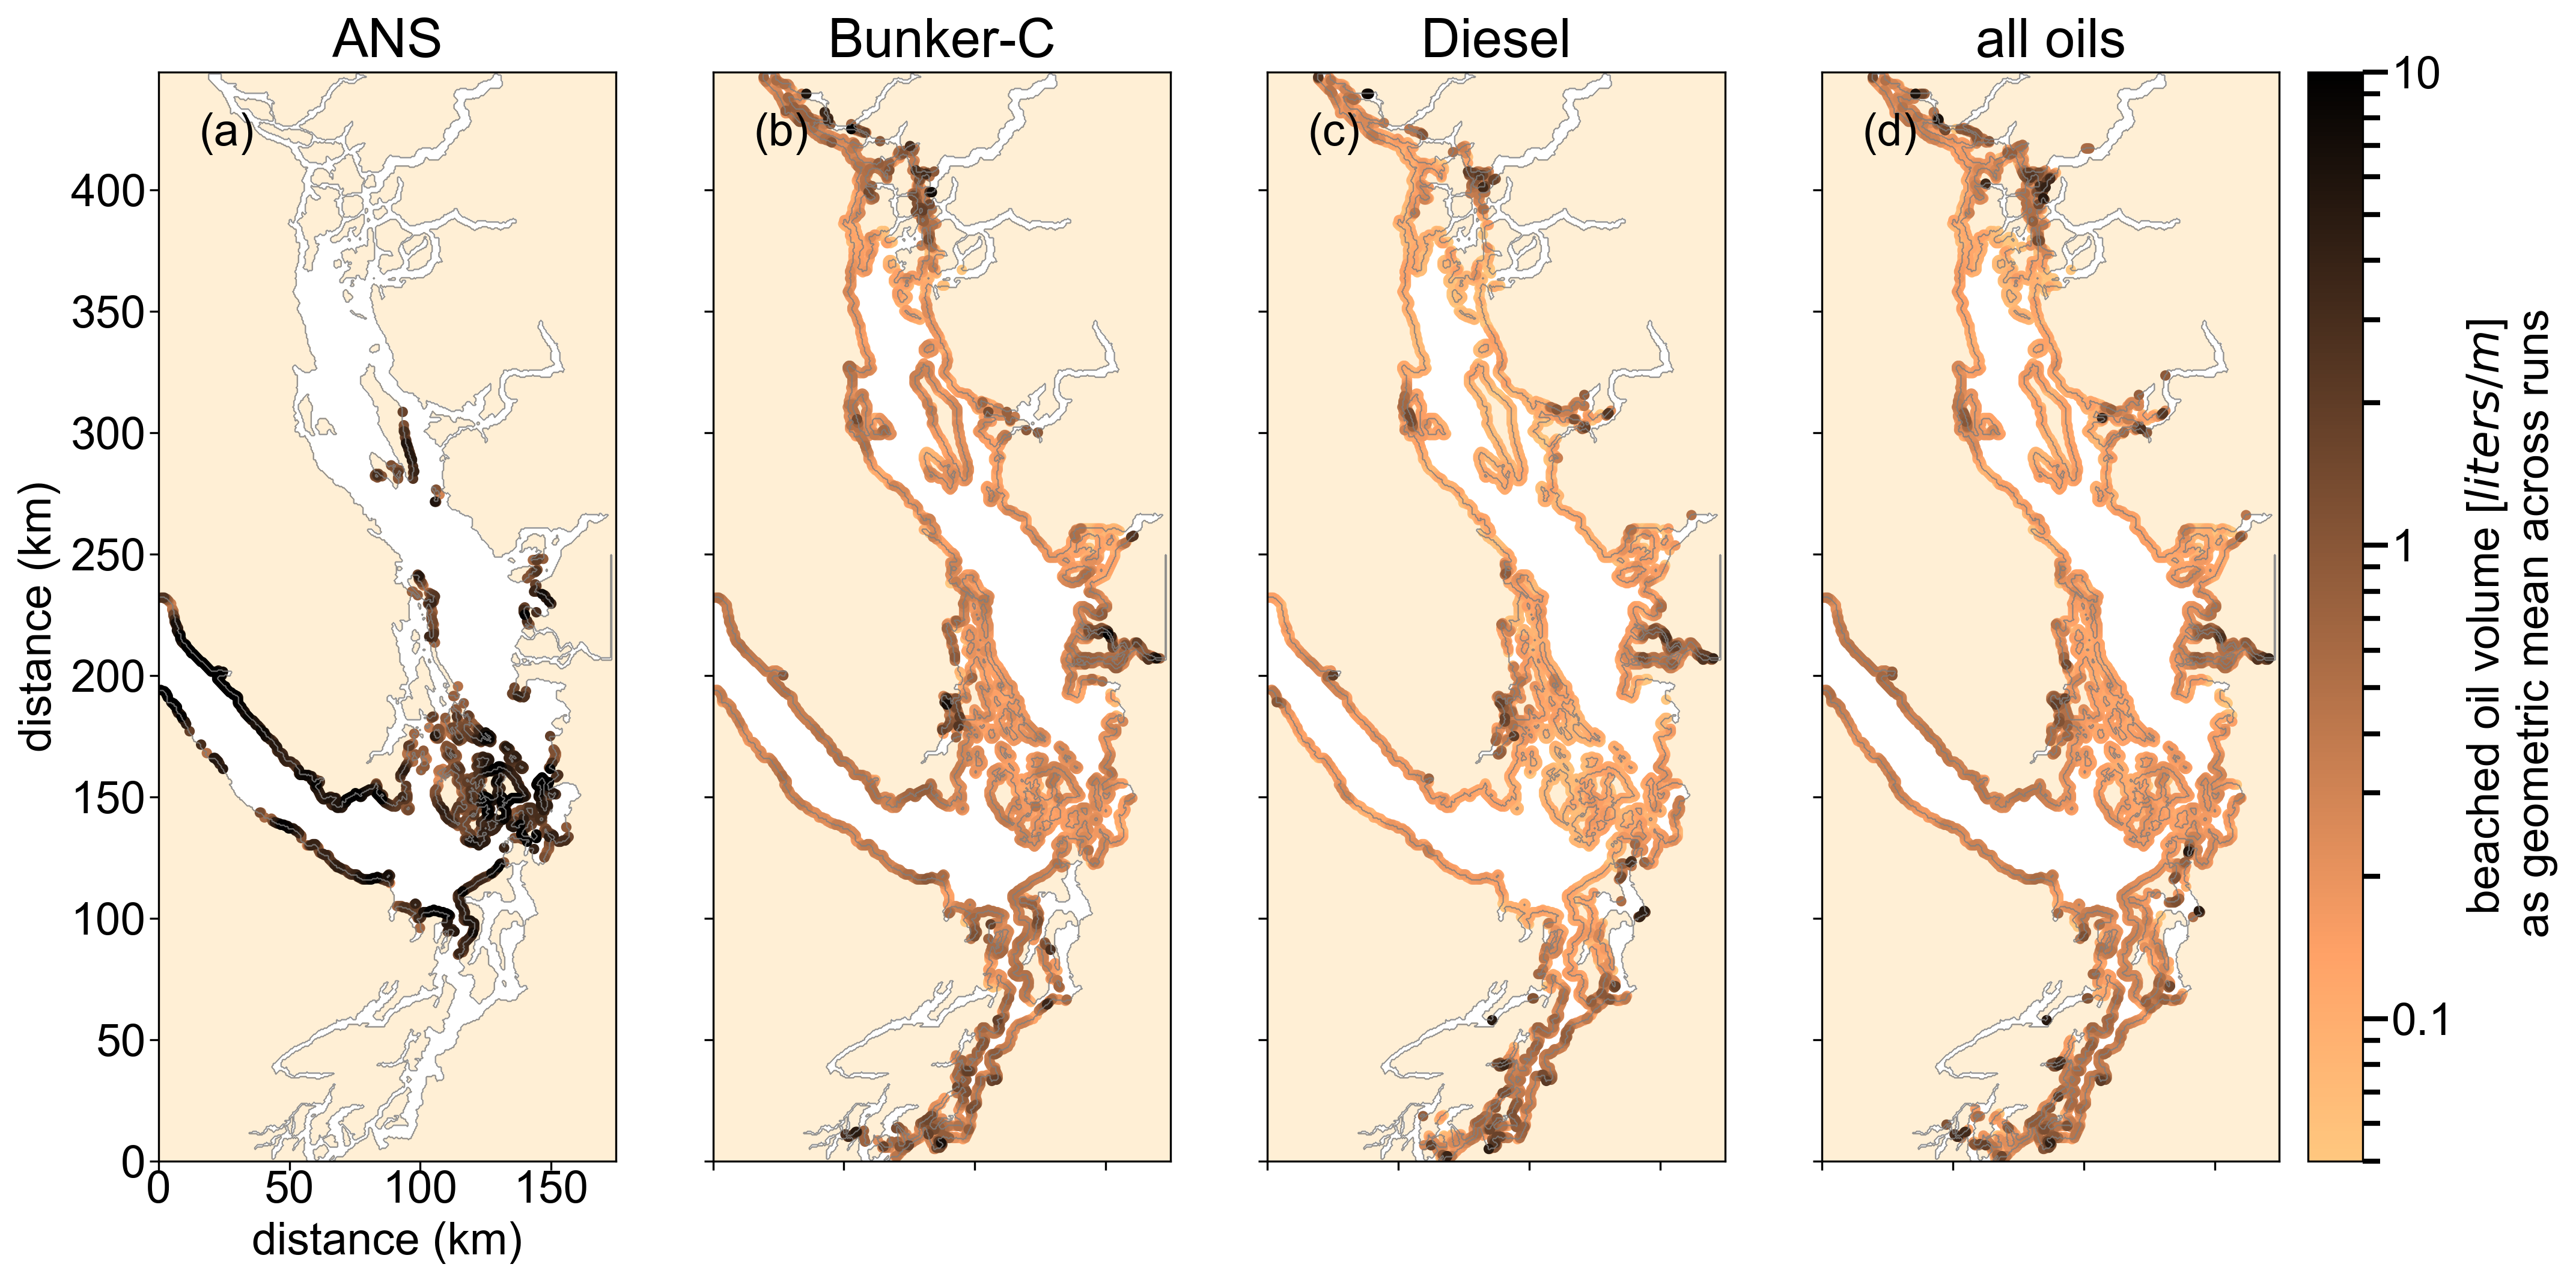

In [9]:
oil_types = ['akns','bunker','diesel','oils']

fig, ax = plt.subplots(1,len(oil_types), figsize = (16,8),
          gridspec_kw={'width_ratios': [1 ,1, 1, 1.25]})

# Add plots for different oil types
for idx,oilname in enumerate(oil_types):
    # create dataframe for oil type
    beached_oil = np.exp(beachedoil[oilname]) * alength * 1000
    # get the x,y values in vector form
    coords=np.asarray(np.argwhere(beached_oil))
    x, y = coords[:, 0], coords[:, 1]
    # get the beached oil in vector form
    beached_oil_1d = beached_oil.compressed()
    df = pd.DataFrame(data={'x': x,
                        'y': y,
                        'z': beached_oil_1d})
    df.sort_values('z', ascending=True, inplace=True)
    # plotting the land mask
    ax[idx].pcolormesh(1.8*tmask[1:, 1:], cmap=my_cmap, 
                  vmin=.1, vmax=.8)
    ax[idx].contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    #ax[idx].contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    sc=ax[idx].scatter(df.y,df.x,c=df.z, 
                  s=10, 
                  cmap = 'copper_r',
                 norm=colors.LogNorm(vmin=0.05, vmax=10))
    # Use dx=440/1000 scale to make "nice" x-axis label intervals 
    xticks = np.arange(0, 200, 50)/.44
    ax[idx].set_xticks(xticks)
    if idx != 0:
        ax[idx].set_xticklabels('')
        ax[idx].set_yticklabels('')
    else:
        # convert axis labels to km
        ax[idx].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000)))
        ax[idx].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000)))

        ax[idx].set_ylabel('distance (km)')
        ax[idx].set_xlabel('distance (km)')
    ax[idx].set_title(oil_dict[oilname])

cbar = plt.colorbar(
    sc,
    orientation='vertical',
    ticks=[0.1, 1, 10]
)
cbar.ax.set_yticklabels(['0.1', '1', '10'])
cbar.ax.tick_params(which='both', width=2)
cbar.ax.tick_params(which='major', length=10)
cbar.ax.tick_params(which='minor', length=7, color='k')
cbar.set_label('beached oil volume [$liters/m$]\nas geometric mean across runs ');

for idx in [0,1,2,3]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)

plt.savefig(graphics_directory/'Figure13_MuellerEtAlJGR_beached_volume.png')

# timescale 

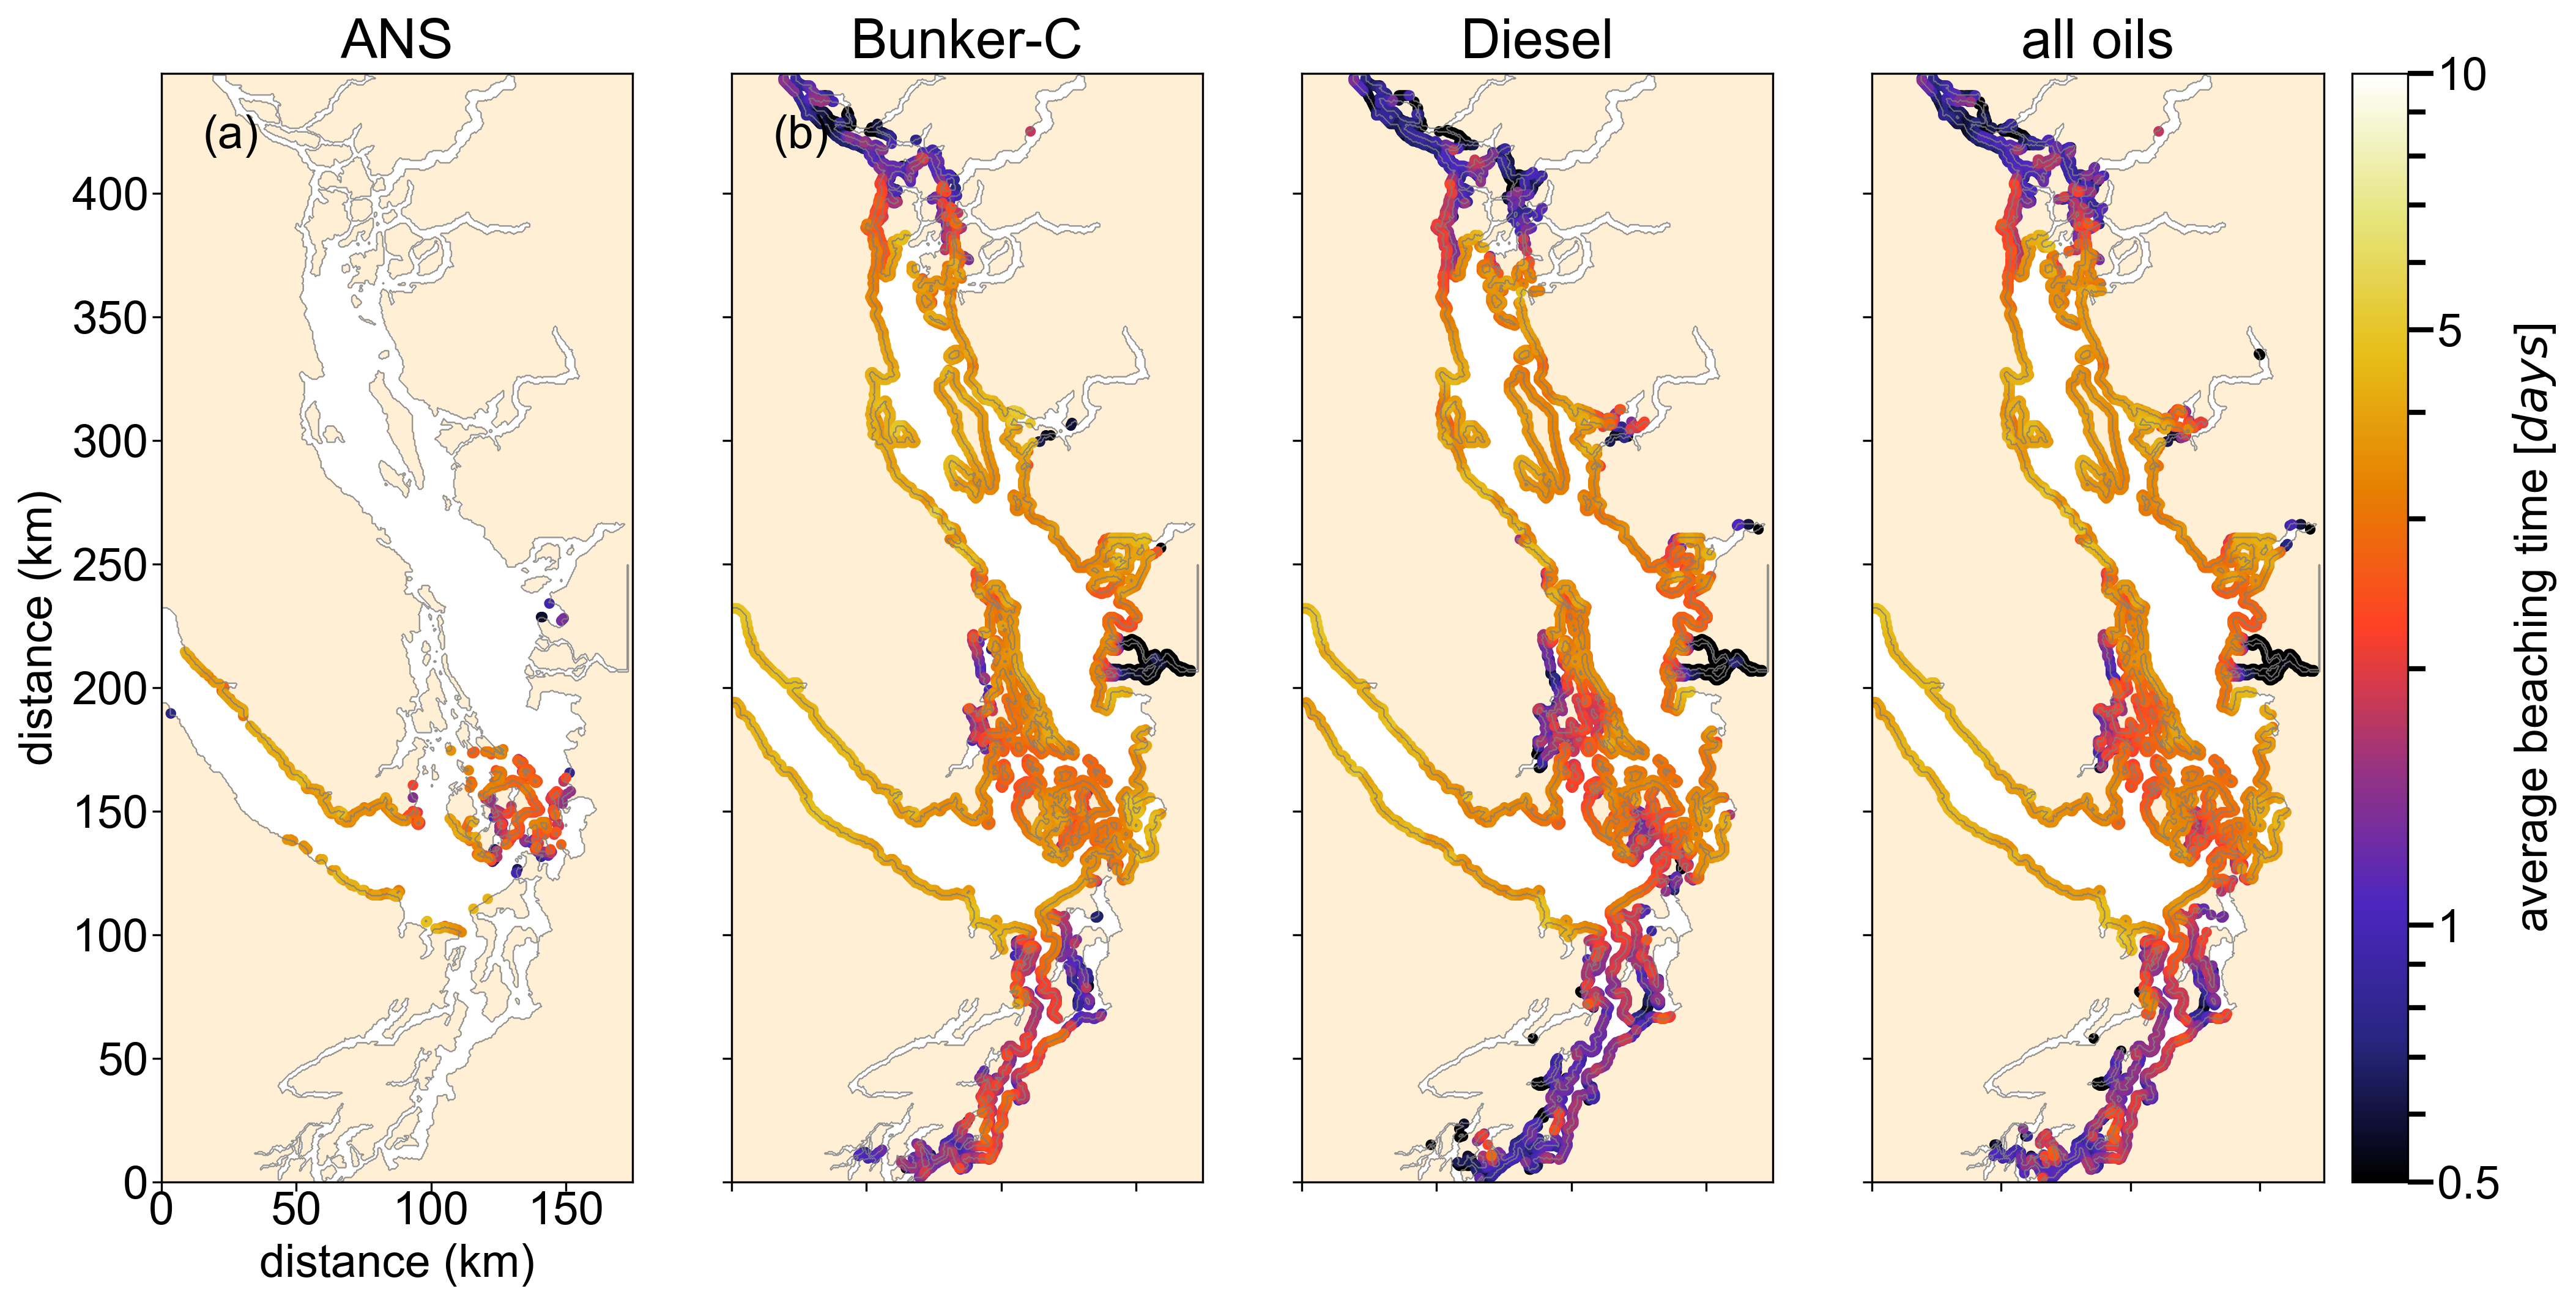

In [10]:
# set fontsize
fs = 36
oil_types = ['akns','bunker','diesel','oils']

fig, ax = plt.subplots(1,len(oil_types), figsize = (16,8),
          gridspec_kw={'width_ratios': [1 ,1, 1, 1.2]})
# Add plots for different oil types

for idx,oilname in enumerate(oil_types):
    # create dataframe for oil type
    beached_time = beachedtime[oilname] 
    # get the x,y values in vector form
    coords=np.asarray(np.argwhere(beached_time))
    x, y = coords[:, 0], coords[:, 1]
    # get the beached oil in vector form
    beached_time_1d = beached_time.compressed()
    df = pd.DataFrame(data={'x': x,
                        'y': y,
                        'z': beached_time_1d})
    df.sort_values('z', ascending=True, inplace=True)
    # plotting the land mask
    ax[idx].pcolormesh(1.8*tmask[1:, 1:], cmap=my_cmap, 
                  vmin=.1, vmax=.8)
    ax[idx].contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    sc=ax[idx].scatter(df.y,df.x,c=df.z, 
                  s=10, 
                  cmap = 'CMRmap',
                 norm=colors.LogNorm(vmin=0.5,vmax=10))
    # Use dx=440/1000 scale to make "nice" x-axis label intervals 
    xticks = np.arange(0, 200, 50)/.44
    ax[idx].set_xticks(xticks)
    if idx != 0:
        ax[idx].set_xticklabels('')
        ax[idx].set_yticklabels('')
    else:
        # convert axis labels to km
        ax[idx].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000)))
        ax[idx].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000)))
        ax[idx].set_ylabel('distance (km)')
        ax[idx].set_xlabel('distance (km)')
        
    ax[idx].set_title(oil_dict[oilname])
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax[idx])
#cax = divider.append_axes('right', size="20%", pad=0.8,)
#cbar = fig.colorbar(sc, cax=cax, orientation='vertical');
cbar = plt.colorbar(sc,
                orientation='vertical',
                 ticks=[0.5, 1, 5, 10])
cbar.ax.tick_params() 
cbar.ax.set_yticklabels(['0.5', '1', '5', '10'])
cbar.ax.tick_params() 
cbar.ax.tick_params(which='both', width=2)
cbar.ax.tick_params(which='major', length=10)
cbar.ax.tick_params(which='minor', length=7, color='k')
cbar.set_label('average beaching time [$days$]');

for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)

plt.savefig(graphics_directory/'Figure14_MuellerEtAlJGR_beached_time.png')